## 0. Import Libraries

In [78]:
from glob import glob
from metpy.units import units
from shapely.geometry import mapping
from matplotlib.patches import Patch
from cartopy.feature import ShapelyFeature
from collections import Counter
from matplotlib.patches import Patch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import geopandas as gpd
import seaborn as sns
import cartopy.io.shapereader as shpreader 

import rioxarray
import cartopy
import matplotlib
import proplot

## 1. Parameters

In [2]:
# general path
path_general = 'data'

## 2. Open Data

In [3]:
data_lu = rioxarray.open_rasterio(fr'{path_general}/land_use_data.tiff').squeeze()

In [4]:
data_lu.rio.crs

CRS.from_epsg(4326)

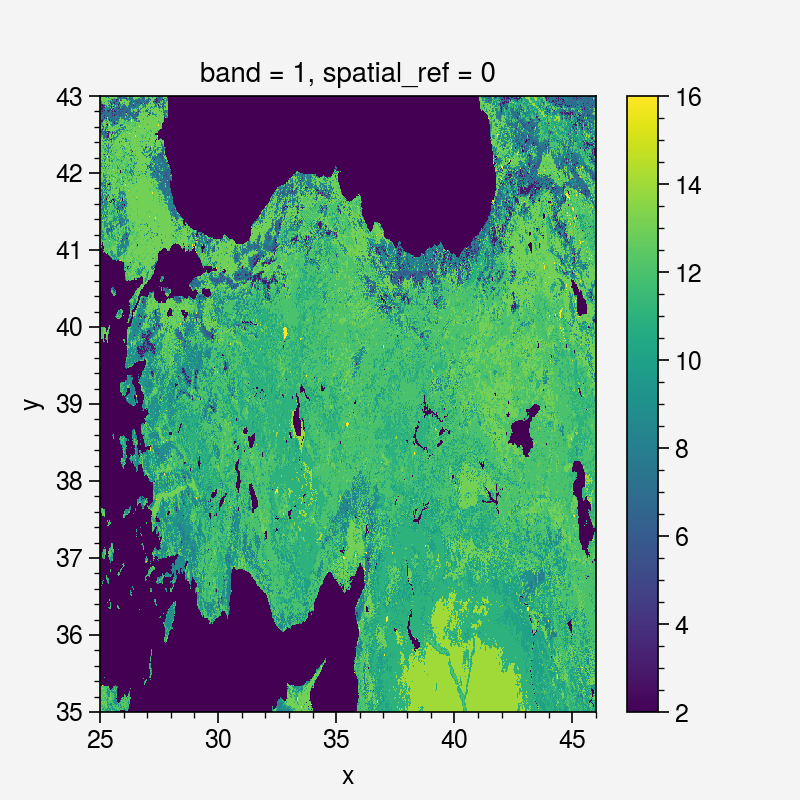

In [5]:
data_lu.plot()

## 3. Clip to Turkey

In [6]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [7]:
path_shape = fr'{path_general}/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_tr = gpd.read_file(path_shape)

In [8]:
data_lu_tr = clip_to_city(data_lu, shape_tr)

# change 0 to np.nan
data_lu_tr = data_lu_tr.where(data_lu_tr != 0, np.nan)

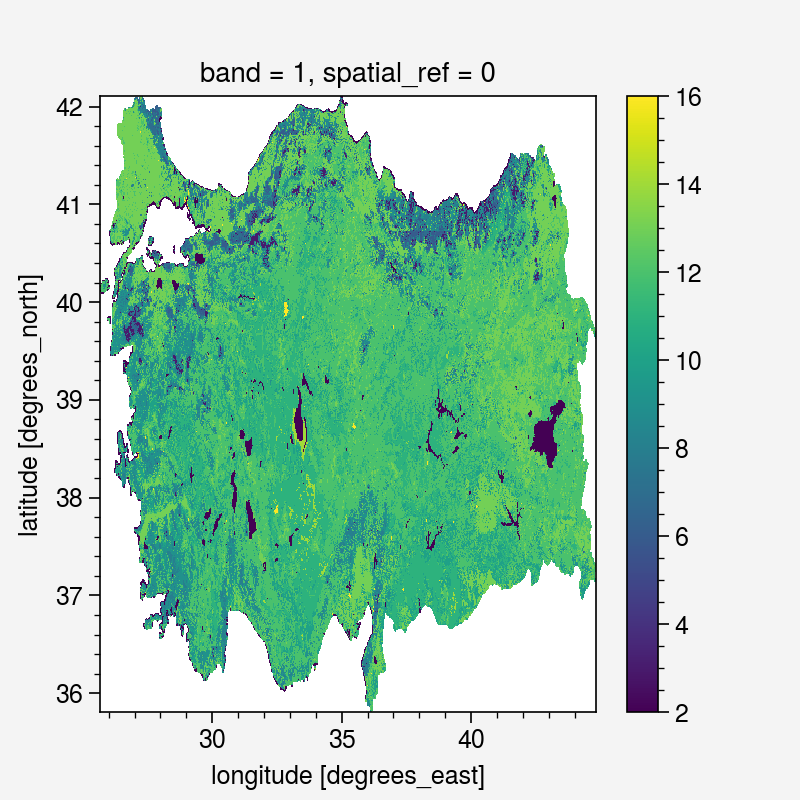

In [9]:
data_lu_tr.plot()

## 4. Land Use Proportions

In [77]:
cb_list = [
    '#9be3ff',
    '#009200',
    '#00b900',
    '#006900',
    '#009d86',
    '#70cdc0',
    '#c8bb27',
    '#929292',
    '#797100',
    '#b3b098',
    '#fcee81',
    '#f00',
]

labels = ['water', 'Evergreen Needleleaf Forest',
       'Deciduous Broadleaf Forest', 'Mixed Forest', 'Woodland',
       'Wooded Grassland', 'Closed Shrubland', 'Open Shrubland',
       'Grassland', 'Cropland', 'Bare Ground', 'Urban and Built-up']

In [19]:
data_lu_tr.values.reshape(-1)

data_lu_tr_reshaped = data_lu_tr.values.reshape(-1)
data_lu_tr_notisnan = data_lu_tr_reshaped[~np.isnan(data_lu_tr_reshaped)]

In [22]:
dict(Counter(data_lu_tr_notisnan))

{8.0: 58121,
 9.0: 120614,
 13.0: 206670,
 2.0: 27810,
 6.0: 11505,
 7.0: 8705,
 3.0: 12455,
 12.0: 466647,
 10.0: 109866,
 16.0: 1429,
 11.0: 148106,
 14.0: 4364}

In [64]:
lu_pd  = pd.DataFrame(dict(Counter(data_lu_tr_notisnan)), index=['count'])\
                    .T \
                    .reset_index() \
                    .rename(columns={'index':'lu'})

In [65]:
lu_pd = lu_pd.sort_values('lu',)
lu_pd['cmap'] = cb_list

In [66]:
lu_pd['lu'] = lu_pd['lu'].astype(np.int64)

In [67]:
lu_pd

,lu,count,cmap
3,2,27810,#9be3ff
6,3,12455,#009200
4,6,11505,#00b900
5,7,8705,#006900
0,8,58121,#009d86
1,9,120614,#70cdc0
8,10,109866,#c8bb27
10,11,148106,#929292
7,12,466647,#797100
2,13,206670,#b3b098


In [68]:
lu_pd['percent'] = lu_pd.apply(lambda row: row['count']/lu_pd['count'] \
                               .sum()*100,
                               axis=1)

In [69]:
lu_pd[['lu', 'percent']].sort_values('percent', ascending=False)#['percent']

,lu,percent
7,12,39.671017
2,13,17.569617
10,11,12.590921
1,9,10.253747
8,10,9.340028
0,8,4.941035
3,2,2.364209
6,3,1.058836
4,6,0.978073
5,7,0.740037


## 5. Land Use Graphic

### 5.1 Options

In [10]:
# make a color map of fixed colors
cmap = matplotlib.colors.ListedColormap(cb_list)
unique = np.unique(data_lu_tr)
unique = unique[~np.isnan(unique)]
bounds= np.concatenate([np.array([0]), unique,])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N,)

In [45]:
# Parameters to change (plot) -------------------
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(central_longitude=35.0,
                                   central_latitude=39.0,
                                   globe=globe)

# fig features
fig_array = [[1, 1],
             [2, 2]
            ]
graphic_no = 2

In [16]:
data_lu_tr

<xarray.DataArray (y: 756, x: 2299)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 42.1 42.1 42.09 42.08 ... 35.84 35.83 35.82 35.81
  * x            (x) float64 25.67 25.68 25.69 25.7 ... 44.8 44.8 44.81 44.82
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### 5.2 Plot

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  return func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  return func(self, *args, **kwargs)


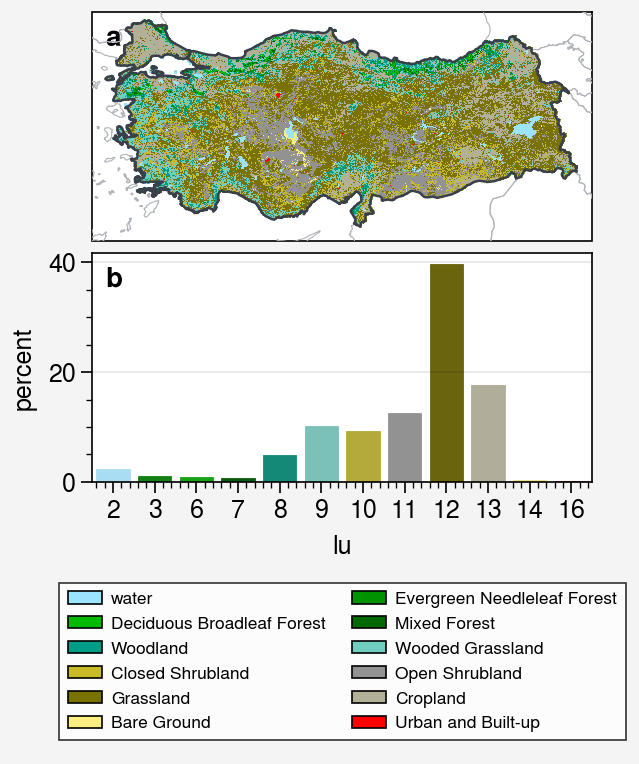

In [87]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            #figsize=(10,6),
                            #aspect=10,
                            #axwidth=5,
                            proj=[lcc, None],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.50,
                            wspace=0.4,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc=True,
           zorder=50)

# ankara limits d01
axs[0].format(lonlim=(25.8, 45.1), 
           latlim=(35., 42.2), 
           longrid=False, 
           latgrid = False)

# shapefile
# External complementary shapefiles
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
cts = ['Syria', 'Iraq', 'Iran',
       'Azerbaijan', 'Armenia',
       'Russia', 'Georgia', 'Bulgaria',
       'Greece', 'Cyprus', 'Northern Cyprus']
    
# add external shapefile geometries
for country in shpreader.Reader(shpfilename).records():
    
    if country.attributes['ADMIN'] in cts:
        
        count_shp = country.geometry
        for i in range(1):
            axs[0].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='none', edgecolor = '#b0b3b8',
                              linewidth = 0.4, zorder = 21,)
            
    elif country.attributes['ADMIN'] == 'Turkey':
        count_shp = country.geometry
        for i in range(1):
            axs[0].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='none', edgecolor = '#3a404a',
                              linewidth = 0.9, zorder = 22,)
            
axs[0].pcolormesh(data_lu_tr['x'].values, data_lu_tr['y'].values,
                      data_lu_tr.values-0.5, cmap=cmap, norm=norm, 
                      transform=cartopy.crs.PlateCarree(), zorder=9)

# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(cb_list))
bar = sns.barplot(data=lu_pd, y='percent', x='lu', ax=axs[1], palette=customPalette)

custom_lines = []
for i, cb_col in enumerate(cb_list):

    custom_lines.append(Patch(facecolor=cb_col,
                               edgecolor='k',
                               label=labels[i]))
    
leg = fig.legend(custom_lines, 
           labels=labels,
           ncols = 2,
           loc = 'bottom',
           prop={'size': 6.25})

#save figure
plt.savefig(r'pictures/urban_proportion.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=300)

## 6. Grid Amounts for Each Land Use

In [89]:
# table for grid total amount
lu_pd[['lu', 'count']].reset_index(drop=True)

,lu,count
0,2,27810
1,3,12455
2,6,11505
3,7,8705
4,8,58121
5,9,120614
6,10,109866
7,11,148106
8,12,466647
9,13,206670
